# Revenue of Hosts Per Month

In this notebook the monthly revenue in $ is investigated based on the AirBnB data from Seattle.

The revenue is calculated based on assumptions for the fraction of people staying at the host and not writing a review and an average number for the duration of each stay.

The monthly revenue per listing is approximated by:
* calculating the months the listings was in use (time period from the first review to the last in months)
* counting the reviews during this time to determine the reviews per months
* assume that only 50 % of the guests leave a review to obtain the number of guests per month
* assume that guests stay on average 3 nights (also used in the model here) to finally calculate the monthly revenue together with an average price per night

At first the data is understood and processed, then statistics are calculated to provide information about the revenue of the hosts and how the overall revenue is distributed among the hosts.

In [1]:
import datetime
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="ticks")

# load the data from the listing
df_list = pd.read_csv("./listings.csv")
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [2]:
# load the reviews into a pandas dataframe
df_rev = pd.read_csv("./reviews.csv")
df_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
# inspect the datatypes
df_rev.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [7]:
# nan values and their occurances
df_rev.isnull().mean()

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64

In [3]:
# calculate how many reviews each listing has
df_rev_per_list = df_rev["listing_id"].value_counts().reset_index()
# rename columns to merge with original dataframe again
df_rev_per_list.columns = ["id", "total_reviews"]
# merge dataframes on the listing id
df_merged = pd.merge(df_list, df_rev_per_list, on=["id"])
df_merged.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,total_reviews
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,207
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,43
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,20
3,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,38
4,5956968,https://www.airbnb.com/rooms/5956968,20160104002432,2016-01-04,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,none,This part of Queen Anne has wonderful views an...,...,f,NaN,WASHINGTON,f,strict,f,f,1,2.45,17


In [4]:
# only keep the columns of interest for revenue calculation
df_merged_r = df_merged[["id", "host_id", "first_review", "last_review", "total_reviews", "price"]].copy()
df_merged_r.dtypes

id                int64
host_id           int64
first_review     object
last_review      object
total_reviews     int64
price            object
dtype: object

In [5]:
# convert review dates into datetime
df_merged_r["first_review"] = pd.to_datetime(df_merged_r["first_review"])
df_merged_r["last_review"] = pd.to_datetime(df_merged_r["last_review"])
df_merged_r.dtypes

id                        int64
host_id                   int64
first_review     datetime64[ns]
last_review      datetime64[ns]
total_reviews             int64
price                    object
dtype: object

In [7]:
# because of the dollar sign the price column is of object type
# need to convert this column to numeric values

# lambda function to convert price columns into float columns
dollar_to_num = lambda col: float(str.replace(str(col), "$", "").replace(",", "")) 

# convert
df_merged_r["price"] = df_merged_r["price"].apply(dollar_to_num)

In [8]:
# calculate how many months have passed between the first and last review
df_merged_r['nb_months'] = ((df_merged_r.last_review - df_merged_r.first_review)/np.timedelta64(1, 'M'))
df_merged_r['nb_months'] = df_merged_r['nb_months'].astype(float)
# inspect how many listings have just one review
df_merged_r[df_merged_r["nb_months"] == 0].shape

(311, 7)

In [9]:
# calculate the reviews per months 
df_merged_r["reviews_per_month"] = df_merged_r["total_reviews"]/df_merged_r["nb_months"]
# replace inf values  (where nb_months was 0) with the mean value of the other listings
mean_reviews_per_month = np.mean(df_merged_r[df_merged_r["reviews_per_month"] != np.inf]["reviews_per_month"])
df_merged_r["reviews_per_month"] = df_merged_r["reviews_per_month"].replace(np.inf, mean_reviews_per_month)
# get statistics
df_merged_r.describe()

,id,host_id,total_reviews,price,nb_months,reviews_per_month
count,3.191000e+03,3.191000e+03,3191.000000,3191.000000,3191.000000,3191.000000
mean,5.024827e+06,1.438736e+07,26.590097,127.098402,10.947564,3.496895
std,2.802502e+06,1.344732e+07,39.840788,90.155222,12.936549,3.703960
min,4.291000e+03,4.193000e+03,1.000000,22.000000,0.000000,0.044859
25%,2.712948e+06,3.074414e+06,4.000000,75.000000,1.807019,1.521844
50%,5.308339e+06,9.469827e+06,13.000000,100.000000,5.651040,3.159537
75%,7.467034e+06,2.350056e+07,31.000000,150.000000,15.606070,4.348125
max,1.024814e+07,5.076344e+07,474.000000,1000.000000,77.373252,60.873750


In [11]:
# display the first rows
df_merged_r.head()

,id,host_id,first_review,last_review,total_reviews,price,nb_months,reviews_per_month
0,241032,956883,2011-11-01,2016-01-02,207,85.0,50.037988,4.136857
1,953595,5177328,2013-08-19,2015-12-29,43,150.0,28.320910,1.518313
2,3308979,16708587,2014-07-30,2015-09-03,20,975.0,13.141954,1.521844
3,278830,1452570,2012-07-10,2015-10-24,38,450.0,39.458716,0.963032
4,5956968,326758,2015-06-11,2015-09-28,17,120.0,3.581182,4.747036


In [12]:
# define a function to calculate the revenue based on the model
def calc_revenue(reviews, price, nights_per_stay=3, review_to_booking_rate=0.5):
    """
    Calculat the revenue per month.
    
    INPUT
    reviews - Number of reviews per month per listing
    price - The price of the listing per night as a number
    nights_per_stay - Parameter how long guest stay on average in a listing
    review_to_booking_rate - Parameter describing which portion of the guests actually write a review
    
    OUTPUT
    revenue - Revenue of the listing per month based on the above input parameters
    """
    bookings = ( 1/ review_to_booking_rate) * reviews
    revenue = bookings * nights_per_stay * price
    return revenue

df_merged_r["revenue_month"] = df_merged_r.apply(lambda x: calc_revenue(x.reviews_per_month, x.price), axis=1)


Text(0.5, 0, 'Revenue per Property [$/month]')

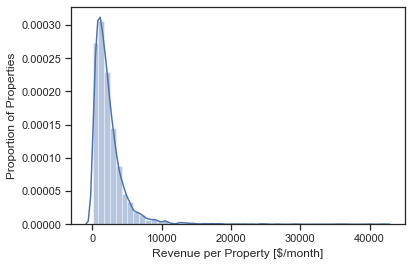

In [13]:
# first visualization of revenue
g = sns.distplot(df_merged_r["revenue_month"])
g.set_ylabel("Proportion of Properties")
g.set_xlabel("Revenue per Property [$/month]")

In [20]:
# investigate multi listings - how many listings have the hosts
df_merged_r.groupby(["host_id"]).count()["id"].sort_values(ascending=False)[:5]

host_id
8534462    41
4962900    37
3074414    34
74305      31
430709     29
Name: id, dtype: int64

In [21]:
# calculate the revenue per host and sort the values in non-ascending order
df_merged_r.groupby(["host_id"]).sum()["revenue_month"].sort_values(ascending=False)[:10]

host_id
8534462     216369.951630
5325329      67641.411198
658155       66728.391749
430709       63243.940563
42537846     48069.245180
24272378     42002.887500
4962900      39357.918053
10558142     37818.589061
754810       36609.556994
40885963     36159.007500
Name: revenue_month, dtype: float64

In [22]:
# inspect the data on which the calculations are done for the host with the by far most revenue
df_merged_r[df_merged_r["host_id"] == 8534462][:5]

,id,host_id,first_review,last_review,total_reviews,price,nb_months,reviews_per_month,revenue_month
918,3380159,8534462,2014-07-01,2015-10-21,50,199.0,15.671780,3.190448,3809.395047
973,6913706,8534462,2015-06-26,2015-11-13,20,183.0,4.599684,4.348125,4774.241250
976,6990477,8534462,2015-07-05,2015-11-08,26,183.0,4.139715,6.280625,6896.126250
980,7840228,8534462,2015-08-16,2015-09-21,6,183.0,1.182776,5.072812,5569.948125
1038,6766708,8534462,2015-06-19,2015-08-07,3,350.0,1.609889,1.863482,3913.312500


In [23]:
# inspect the original listing data for this host
df_list[df_list["host_id"] == 8534462][:5]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1077,3380159,https://www.airbnb.com/rooms/3380159,20160104002432,2016-01-04,Pike's Place. 100 Walkscore,"With a 100% Walk-Score, this spacious 1BD apar...","With a 100% Walk-Score, this spacious 1BD apar...","With a 100% Walk-Score, this spacious 1BD apar...",none,NaN,...,9.0,f,NaN,WASHINGTON,f,strict,t,t,3,2.71
1149,6913706,https://www.airbnb.com/rooms/6913706,20160104002432,2016-01-04,Westlake Ave Downtown Condos 1BD,98 Walkscore unit on a high floor right downto...,*About the Neighborhood* The neighborhood is r...,98 Walkscore unit on a high floor right downto...,none,NaN,...,9.0,f,NaN,WASHINGTON,f,strict,t,t,3,3.11
1152,9885225,https://www.airbnb.com/rooms/9885225,20160104002432,2016-01-04,Westlake Ave Downtown Condos 1BD 4,"98 Walkscore Penthouse unit on the top floor, ...",NaN,"98 Walkscore Penthouse unit on the top floor, ...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,strict,t,t,3,NaN
1155,6990477,https://www.airbnb.com/rooms/6990477,20160104002432,2016-01-04,Westlake Ave Downtown Condos 1BD 2,98 Walkscore unit on a high floor right downto...,Other units in the same building: https://www...,98 Walkscore unit on a high floor right downto...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,3,4.24
1159,7840228,https://www.airbnb.com/rooms/7840228,20160104002432,2016-01-04,Westlake Ave Downtown Condos 1BD 3,"98 Walkscore Penthouse unit on the top floor, ...",*About the Neighborhood* The neighborhood is r...,"98 Walkscore Penthouse unit on the top floor, ...",none,NaN,...,9.0,f,NaN,WASHINGTON,f,strict,t,t,3,1.27


It seems like the host actually owns so many listings.

In [15]:
# create a dataframe for the revenue per host
df_host = df_merged_r.groupby(["host_id"]).sum()["revenue_month"].sort_values(ascending=False).reset_index()

In [16]:
# calculate the revenue of all hosts
revenue_all = df_host["revenue_month"].sum()

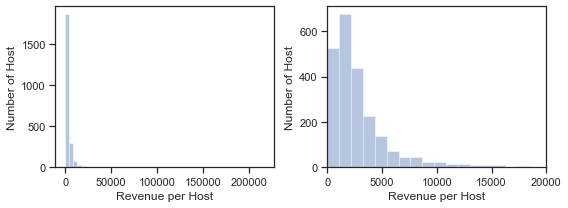

In [17]:
# visualize the distribution of the revenue of the hosts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# plot overall distribution in first plot
ax1 = axes[0]
g = sns.distplot(df_host["revenue_month"], kde=False, ax=ax1)
ax1.set_xlabel('Revenue per Host')
ax1.set_ylabel('Number of Host')
ax1.tick_params(axis='y')

# plot distribution with more bins and only for hosts with a limited revenue
ax2 = axes[1]
g = sns.distplot(df_host["revenue_month"], kde=False, bins=200, ax=ax2)
ax2.set_xlabel('Revenue per Host')
ax2.set_ylabel('Number of Host')
ax2.tick_params(axis='y')
ax2.set_xlim(0, 20000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [19]:
# sort the hosts according to non-decreasing monthly revenue values
revenue_per_host = df_host["revenue_month"].sort_values().reset_index()["revenue_month"]
# create the cumulative sums
cumulative = np.cumsum(revenue_per_host)
norm_cumulative = cumulative / revenue_all

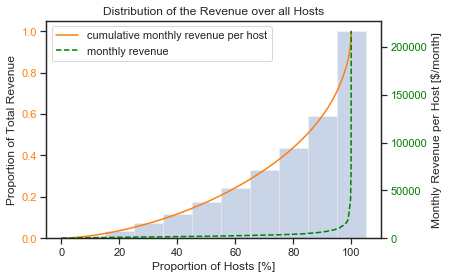

In [20]:
# visualize the revenues
fig, ax1 = plt.subplots()
x_values = 100 * revenue_per_host.keys() / len(norm_cumulative)

color = 'tab:orange'
ax1.set_xlabel('Proportion of Hosts [%]')
ax1.set_ylabel('Proportion of Total Revenue')  #color=color we already handled the x-label with ax1
lns1 = ax1.plot(x_values, norm_cumulative, color=color, zorder=3, label="cumulative monthly revenue per host")
ax1.tick_params(axis='y', labelcolor=color) 

# add bar chart with cumulative values
# create x and y values for bar chart
x_bins = np.arange(0.1, 1.1, 0.1).tolist()
y_bins = []
for i in x_bins:
    index = int(i * len(norm_cumulative))
    try:
        y_bins.append(norm_cumulative[index])
    except:
        y_bins.append(norm_cumulative[len(norm_cumulative)-1])

x_bins_plot = range(10, 110, 10)
ax1.bar(x_bins_plot, y_bins, width=10, zorder=1, alpha=0.3)

# second axis with revenue per months (hosts sorted as well)
ax2 = ax1.twinx()
ax2.set_ylabel('Monthly Revenue per Host [$/month]')
lns2 = ax2.plot(x_values, revenue_per_host.tolist(), label="monthly revenue", zorder=2, color="green", linestyle="--")
ax2.tick_params(axis='y', labelcolor="green")
ax2.set_ylim(bottom=0.0)

# add legend for the two line plots in different axis
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.title("Distribution of the Revenue over all Hosts")
plt.show()

In [21]:
print("Result")
print("50 % of the revenue is generated by roughly {} % of the hosts.".format(round(100 - 100 * np.where(cumulative > 0.5)[0][0] / len(cumulative), 2)))

Result
50 % of the revenue is generated by roughly 100.0 % of the hosts.


In [22]:
# useful statistics
revenue_per_host.describe()

count      2303.000000
mean       3360.719793
std        6365.695504
min          30.390828
25%        1185.654345
50%        2096.314570
75%        3602.430625
max      216369.951630
Name: revenue_month, dtype: float64

In [23]:
print("{} hosts have a revenue > $10,000.".format(np.sum(revenue_per_host > 10000)))

111 hosts have a revenue > $10,000.
